<a href="https://colab.research.google.com/github/BTOCC25/AIStudy-public/blob/main/%EA%B3%B5%EA%B8%B0%EC%95%95%EC%B6%95%EA%B8%B0_%EC%9D%B4%EC%83%81_%ED%8C%90%EB%8B%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
train_csv_path = '/content/drive/MyDrive/Project/ai_factory/공기압축기_이상_판단/data/train_data.csv'
test_csv_path = '/content/drive/MyDrive/Project/ai_factory/공기압축기_이상_판단/data/test_data.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

hp = [] #리스트 생성
for df in [train_df, test_df]:
  for row in df['type']:
      if row in [0, 4, 5, 6, 7]:
          hp.append(30)
      elif row == 1:
          hp.append(20)
      elif row == 2:
          hp.append(10)
      elif row == 3:
          hp.append(50)   
  df['hp'] = hp
  hp = []

train_df.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,hp
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0,30
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0,30
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0,30
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0,30
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0,30


## EDA

In [80]:
train_df.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,hp
count,2463.000000,2463.000000,2.463000e+03,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000
mean,2.128843,49.001137,7.000000e-01,27.490715,2372.576939,65.766707,3.452972,2.957369,28.014616
std,1.202328,8.725091,1.110448e-16,13.604597,687.870774,7.797152,1.576386,2.230113,10.964670
min,0.330000,32.030000,7.000000e-01,5.340000,1201.000000,50.360000,1.970000,0.000000,10.000000
25%,1.280000,41.600000,7.000000e-01,17.110000,1784.500000,59.150000,2.880000,1.000000,20.000000
50%,1.960000,48.980000,7.000000e-01,25.850000,2358.000000,65.640000,3.260000,3.000000,30.000000
75%,2.820000,56.355000,7.000000e-01,36.000000,2971.000000,72.275000,3.730000,5.000000,30.000000
max,6.220000,64.960000,7.000000e-01,72.000000,3564.000000,80.520000,21.870000,7.000000,50.000000


In [81]:
test_df.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,hp
count,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000
mean,2.103129,49.042735,0.699840,27.417935,2373.820003,65.771623,3.345523,2.957369,28.014616
std,1.163998,8.686208,0.005377,13.234089,687.737182,7.741473,0.644199,2.229811,10.963186
min,0.340000,32.080000,0.490000,5.370000,1200.000000,50.420000,1.970000,0.000000,10.000000
25%,1.280000,41.510000,0.700000,17.200000,1774.000000,59.110000,2.890000,1.000000,20.000000
50%,1.940000,48.760000,0.700000,26.170000,2355.000000,65.520000,3.260000,3.000000,30.000000
75%,2.770000,56.580000,0.700000,35.860000,2972.000000,72.440000,3.730000,5.000000,30.000000
max,6.240000,65.540000,0.700000,74.000000,3564.000000,82.390000,6.260000,7.000000,50.000000


train data(모두 정상)를 보면 out_pressure의 값이 모두 7임을 알 수 있음. 그런데 test data(이상치 포함)에는 7이 아닌 값이 몇개 있다.

-> 7이 아닌값에 대해서 anormaly value인지 확인 실험

**설비별 데이터 개수**

In [82]:
train_df['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

**설비별로 나눠서 데이터 그려보기**

우선 type 0, 4, 5, 6, 7이 비슷한 경향인지 그려보자

In [83]:
mask = (train_df['type'] == 0) | (train_df['type'] > 3)
mask_df = train_df.loc[mask, :]

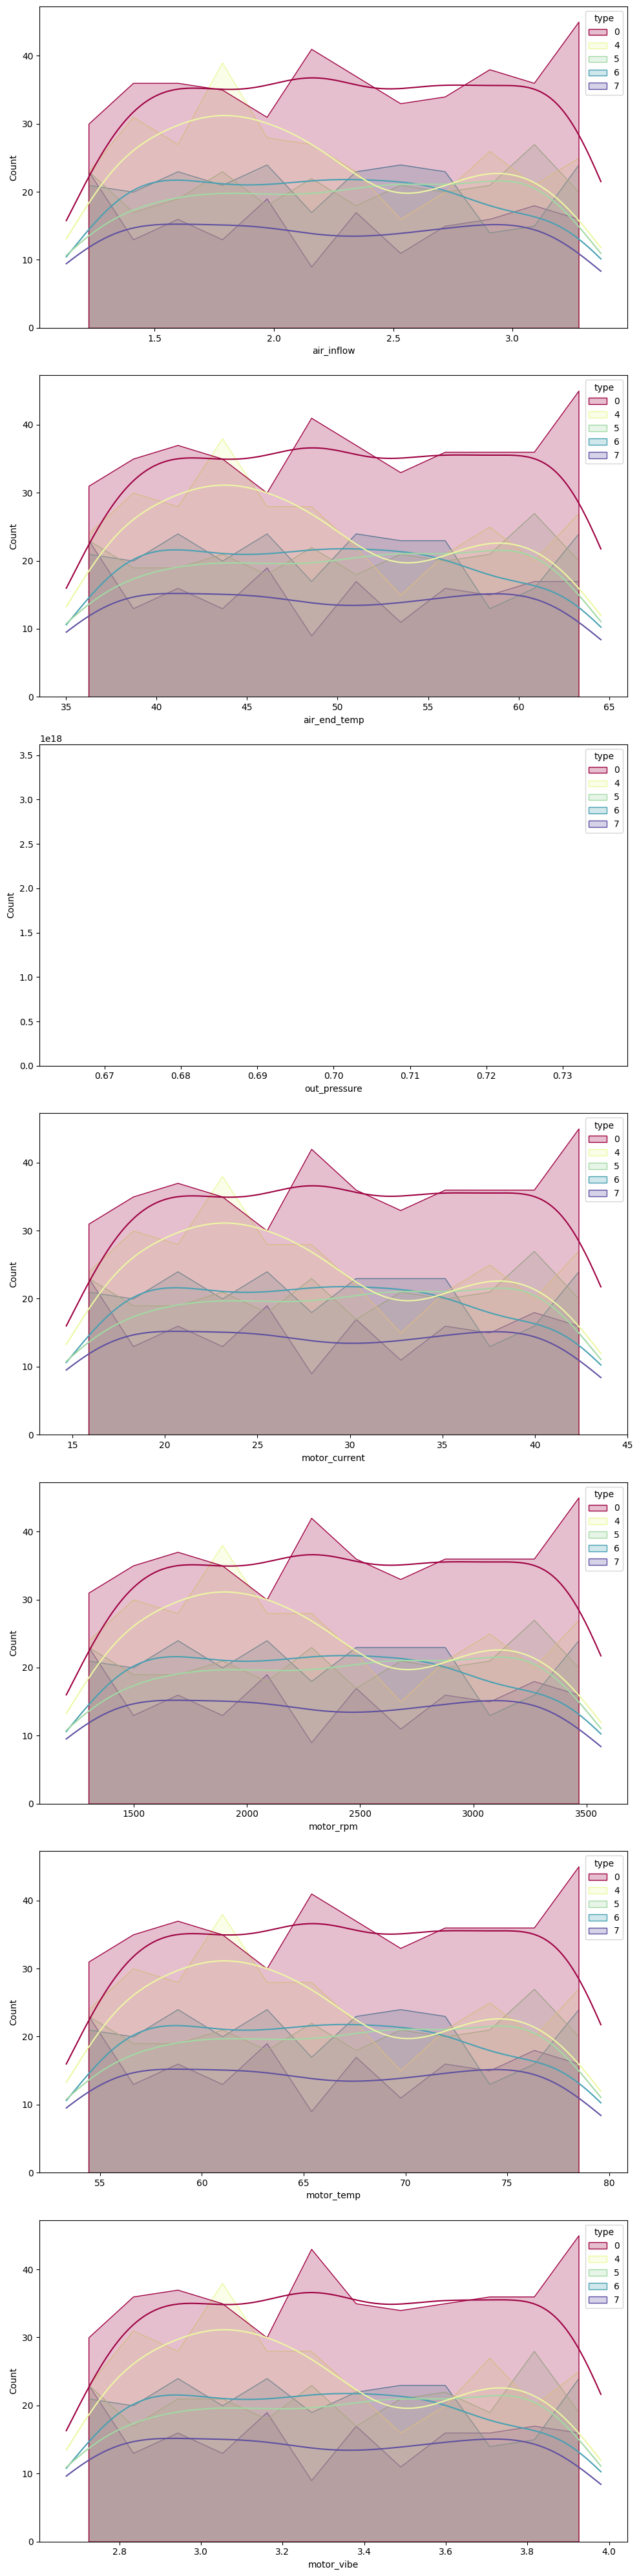

In [84]:
fig, ax = plt.subplots(7, 1)
fig.set_size_inches(10, 40)
features = list(train_df.columns)[:-2]

for i in range(len(features)):
  cur_ax = ax[i]
  sns.histplot(data=mask_df, x=features[i],
                hue='type',
                hue_order=[10, 20, 30, 50],
                palette='Spectral',
                ax=cur_ax,
                element='poly',
                kde=True
               )
  
plt.tight_layout()

4번 type의 경우 값이 앞쪽에 조금 쏠린다는 것을 알 수 있다.

**마력별 데이터 개수**

In [85]:
train_df['hp'].value_counts()

30    1422
20     369
10     366
50     306
Name: hp, dtype: int64

**마력별로 나눠서 데이터 그려보기**

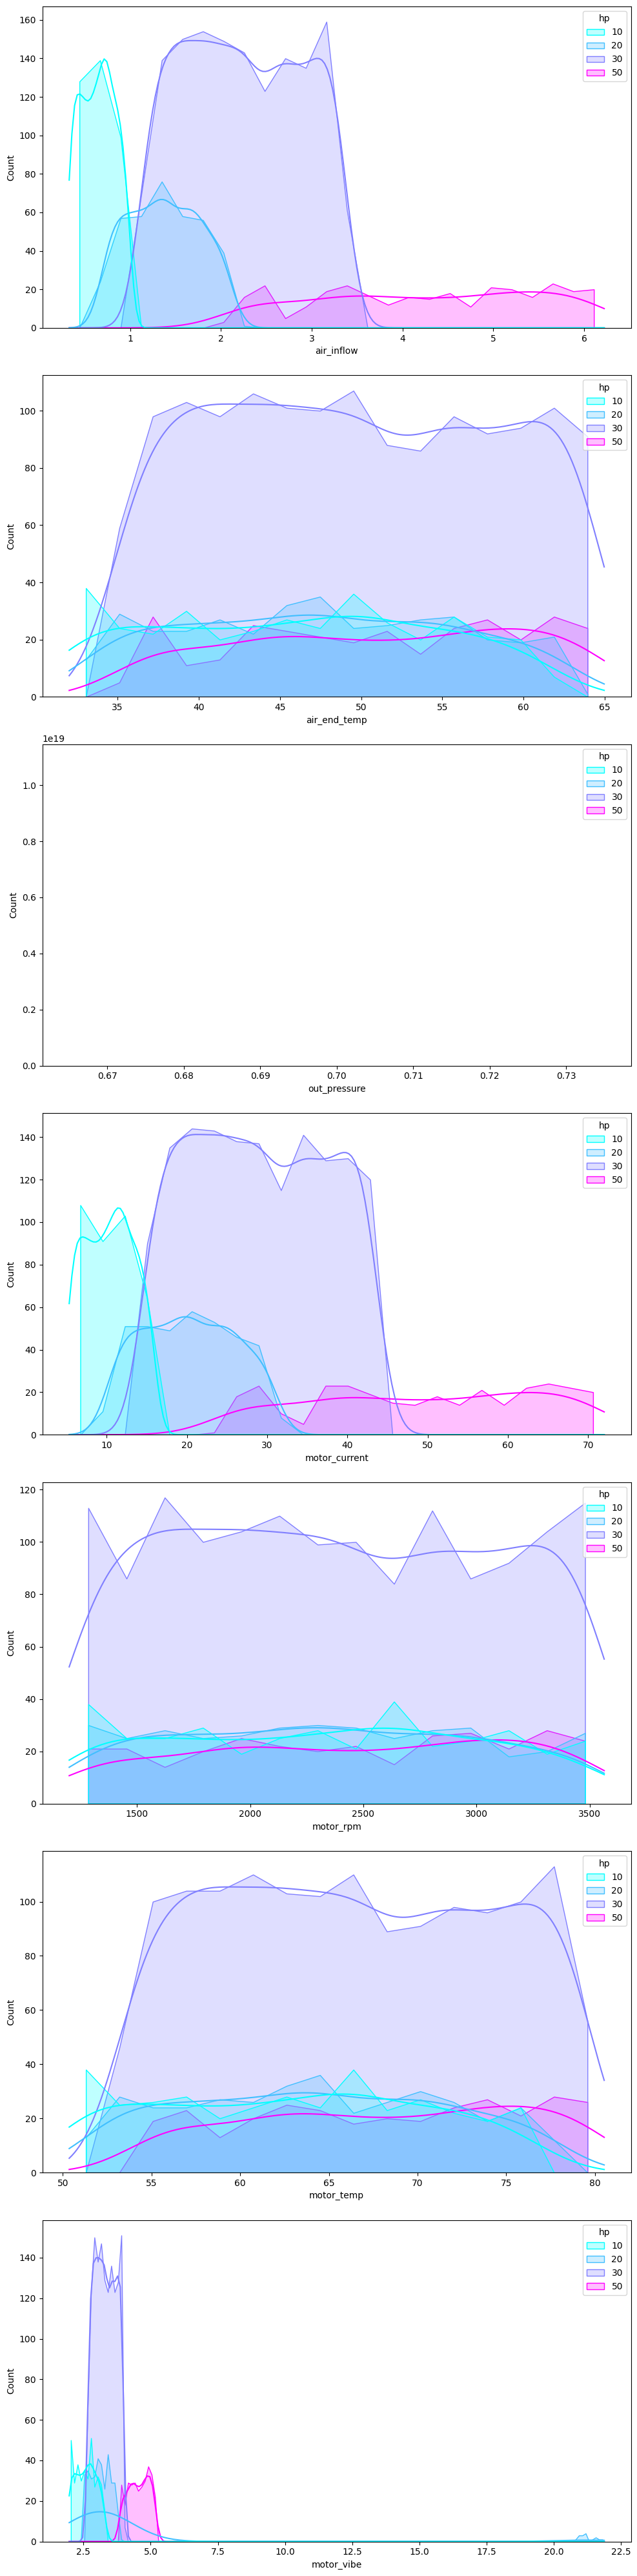

In [86]:
fig, ax = plt.subplots(7, 1)
fig.set_size_inches(10, 40)
features = list(train_df.columns)[:-2]

for i in range(len(features)):
  cur_ax = ax[i]
  sns.histplot(data=train_df, x=features[i],
                hue='hp',
                hue_order=[10, 20, 30, 50],
                palette='cool',
                ax=cur_ax,
                element='poly',
                kde=True
  )
  
plt.tight_layout()

air_inflow, motor_current,motor_vide는 hp 크기의 비례하게 분포함을 알 수 있다.

motor_vibe는 값이 이상하게 튀어도 정상범주다.

나머지는 모든 지표에대해 대부분 고르게 분포되어있다.

## Preprocessing

In [87]:
train_df = train_df.drop(['out_pressure', 'type'], axis=1) # 필요없는 feature 삭제
train_df.shape

(2463, 7)

## model

In [88]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, input_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [89]:
# Define the F1 score loss function
class F1Loss(nn.Module):
    def __init__(self):
        super(F1Loss, self).__init__()

    def forward(self, y_pred, y_true):
        tp = (y_pred * y_true).sum(dim=1)
        fp = ((1 - y_true) * y_pred).sum(dim=1)
        fn = (y_true * (1 - y_pred)).sum(dim=1)
        p = tp / (tp + fp + 1e-10)
        r = tp / (tp + fn + 1e-10)
        f1 = 2 * p * r / (p + r + 1e-10)
        loss = 1 - f1.mean()
        return loss

## set hyperparams

In [94]:
# Define the loss function
criterion = F1Loss()

# Set the hyperparameters
input_size = 7 # Size of the input vectors
batch_size = 32
learning_rate = 1e-4
num_epochs = 1000

# Initialize the autoencoder model
autoencoder = Autoencoder(input_size)

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

## train

In [95]:
# Standardize the training data
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
train_mean = torch.mean(train_tensor, dim=0)
train_std = torch.std(train_tensor, dim=0)
train_data = (train_tensor - train_mean) / train_std

In [96]:
# Train the autoencoder
for epoch in range(num_epochs):
    for i in range(0, len(train_data), batch_size):
        # Get a batch of input vectors
        inputs = train_data[i:i+batch_size]
        
        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print the loss after every epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/1000], Loss: 1.0482
Epoch [2/1000], Loss: 0.9281
Epoch [3/1000], Loss: 0.8575
Epoch [4/1000], Loss: 0.7533
Epoch [5/1000], Loss: -0.6272
Epoch [6/1000], Loss: 2.4197
Epoch [7/1000], Loss: 2.0097
Epoch [8/1000], Loss: 1.8265
Epoch [9/1000], Loss: 1.7810
Epoch [10/1000], Loss: 1.7438
Epoch [11/1000], Loss: 1.7111
Epoch [12/1000], Loss: 1.6816
Epoch [13/1000], Loss: 1.6542
Epoch [14/1000], Loss: 1.6282
Epoch [15/1000], Loss: 1.6027
Epoch [16/1000], Loss: 1.5770
Epoch [17/1000], Loss: 1.5485
Epoch [18/1000], Loss: 1.4839
Epoch [19/1000], Loss: 1.3437
Epoch [20/1000], Loss: 1.3198
Epoch [21/1000], Loss: 1.3061
Epoch [22/1000], Loss: 1.2946
Epoch [23/1000], Loss: 1.2933
Epoch [24/1000], Loss: 1.2921
Epoch [25/1000], Loss: 1.2909
Epoch [26/1000], Loss: 1.2898
Epoch [27/1000], Loss: 1.2887
Epoch [28/1000], Loss: 1.2875
Epoch [29/1000], Loss: 1.2864
Epoch [30/1000], Loss: 1.2853
Epoch [31/1000], Loss: 1.2842
Epoch [32/1000], Loss: 1.2830
Epoch [33/1000], Loss: 1.2819
Epoch [34/1000], L

## test

In [97]:
test_df = test_df.drop(['out_pressure', 'type'], axis=1) # 필요없는 feature 삭제
test_df.shape

(7389, 7)

In [98]:
# Standardize the training data
test_tensor = torch.tensor(test_df.values, dtype=torch.float32)
test_data = (test_tensor - train_mean) / train_std
test_data.shape

torch.Size([7389, 7])

## submit

In [147]:
import os

save_path = '/content/drive/MyDrive/Project/ai_factory/공기압축기_이상_판단/submit/'
save_fileName = "1회차.csv"

submit_form_path = '/content/drive/MyDrive/Project/ai_factory/공기압축기_이상_판단/data/answer_sample.csv'
submit_df = pd.read_csv(submit_form_path)
submit_df['label'] = 0

with torch.no_grad():
  # Calculate the reconstruction error
  reconstruction_error = np.mean(np.square(test_data.numpy() - autoencoder(test_data).numpy()), axis=1)

  # Identify the anomalies as the data points with high reconstruction error
  threshold = np.percentile(reconstruction_error, 95) # 분위수
  anomalies = np.where(reconstruction_error > threshold)[0]
  submit_df.loc[anomalies, 'label'] = 1

  submit_df.to_csv(save_path + save_fileName, index=False)